# DORIS BEACONS, COORDINATES AND DPOD PRODUCTS

## DORIS Beacons

To be able to process DORIS data, we need site (i.e. beacon) coordinates in an appropriate reference frame. Such frames are usually either the [ITRF](https://itrf.ign.fr/en/homepage) series or [dpod](https://ids-doris.org/user-corner/combination/dpod.html) the DORIS terrestrial reference frame for Precise Orbit Determination (see ). 

dpod files are published in both ascii/txt format and SINEX ([Solution Independent Exchange](https://www.iers.org/IERS/EN/Organization/AnalysisCoordinator/SinexFormat/sinex.html) format). In the following, we will be using the latter file(s).



## dpod SINEX

```text
+SOLUTION/EPOCHS
*Code PT SOLN T Data_start__ Data_end____ Mean_epoch__
 ADEA  A    1 D 93:003:00000 98:084:11545 95:226:48972
 [...]
 DIOA  A    1 D 93:003:00000 06:136:86399 99:252:86399
 DIOB  A    1 D 06:137:00000 49:365:86399 28:069:43199
```

```text
+SITE/ANTENNA
*Code PT SOLN T Data_start__ Data_end____ Description_________ S/N__
 ADEA  A    1 D 93:003:00000 98:084:11545              ALCATEL -----
 [...]
 DIOA  A    1 D 93:003:00000 06:136:86399              ALCATEL -----
 DIOB  A    1 D 06:137:00000 49:365:86399             STAREC-B -----
```

```text
+SITE/ECCENTRICITY
*Code PT SOLN T Data_start__ Data_end____ AXE Up______ North___ East____
 ADEA  A    1 D 93:003:00000 98:084:11545 UNE   0.5100   0.0000   0.0000
 [...]
 DIOA  A    1 D 93:003:00000 06:136:86399 UNE   0.5100   0.0000   0.0000
 DIOB  A    1 D 06:137:00000 49:365:86399 UNE   0.4870   0.0000   0.0000
```

```text
+SOLUTION/ESTIMATE
*INDEX TYPE__ CODE PT SOLN _REF_EPOCH__ UNIT S __ESTIMATED VALUE____ _STD_DEV___
  [...]
  1045 STAX   DIOB  A    1 00:001:00000 m    2 0.459521244775775E+07 0.91603E-03
  1046 STAY   DIOB  A    1 00:001:00000 m    2 0.203947364204351E+07 0.11829E-02
  1047 STAZ   DIOB  A    1 00:001:00000 m    2 0.391261794724227E+07 0.71032E-03
  1048 VELX   DIOB  A    1 00:001:00000 m/y  2 0.365553151989051E-02 0.56908E-04
  1049 VELY   DIOB  A    1 00:001:00000 m/y  2 0.102895628910227E-01 0.72134E-04
  1050 VELZ   DIOB  A    1 00:001:00000 m/y  2 -.940766212462862E-02 0.44041E-04
```

Coordinate computation follows 
$$
\vec{r} = \vec{r}_{t_0} + \dot{\vec{r}} (t-t_0) + R \vec{\delta r}
$$ 
where $\vec{\delta r}$ is the eccentricity vector.

### Example 1: Exatrapolating beacon coordinates

Given a dpod SINEX file, we can compute/extrapolate coordinates for a given beacon (or list of beacons) using the function  `extract_sinex_coordinates` of the `dsoclasses.sinex` module. The function signature reads: 
```python
extract_sinex_coordinates(dpod_filename, [site1, site2, ...], epoch_of_request, add_eccentricty_vector, [dpod_freq_corrections_file])
```
where the `epoch_of_request` parameter is a python native `datetime.datetime` instance. The call will return a dictionary whos keys a re the (requested) sites and values the extrapolated coordinates. The last parameter (i.e. `dpod_freq_corrections_file`) is optional and if used should be the dpod file holding harmonic amplitudes for the respective SINEX file. These corrections are normally in the range of a few mm and are given for annual and semi-annual signals.

Here is an example:

In [1]:
from dsoclasses.sinex import sinex
import datetime
from os.path import join
import numpy as np

data_path = "/home/xanthos/Software/AcademicSoftware/data"
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")

result = sinex.extract_sinex_coordinates(dpod, ['DIOB', 'THUB'], datetime.datetime(2024,1,1,12,0,0), True, dpod_freq_corr)
print(f'Function returned: {result}')

# now get the coordinates of DIOB
print(f'\nDIOB dpod coordinates: {result['DIOB']}')

# or stack them in an np array
print(np.array([result['DIOB']['X'], result['DIOB']['Y'], result['DIOB']['Z']]))

Function returned: {'DIOB': {'X': np.float64(4595212.885302537), 'soln': 1, 'Y': np.float64(2039474.0418619534), 'Z': np.float64(3912618.014756306)}, 'THUB': {'X': np.float64(538110.11568241), 'soln': 2, 'Y': np.float64(-1389031.574493159), 'Z': np.float64(6180995.143742023)}}

DIOB dpod coordinates: {'X': np.float64(4595212.885302537), 'soln': 1, 'Y': np.float64(2039474.0418619534), 'Z': np.float64(3912618.014756306)}
[4595212.88530254 2039474.04186195 3912618.01475631]


### Example 2: Site time series

Using the above, we can easily compute coordinate time series for a given site:

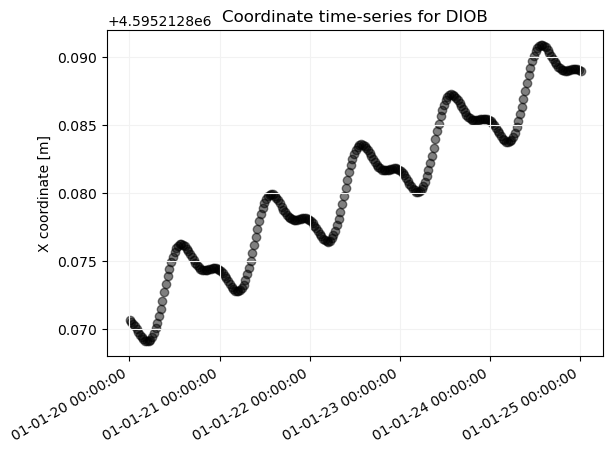

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

t_start = datetime.datetime(2020, 1, 1, 12, 0, 0)
t_stop = datetime.datetime(2025, 1, 1, 12, 0, 0)

# store results to plot later on
ts = []; xs = [];

t = t_start
while t <= t_stop:
    xs.append(sinex.extract_sinex_coordinates(dpod, ['DIOB'], t, True, dpod_freq_corr)['DIOB']['X'])
    ts.append(t)
    t += datetime.timedelta(days=7)

# plot results
plt.scatter(ts, xs, color='black', alpha=0.5)
plt.grid(color='0.95')
plt.ylabel("X coordinate [m]")
plt.title("Coordinate time-series for DIOB")
# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()
plt.show()

## SINEX Data Archive

dpod SINEX files along with the respective frequency corrections and psd files are publicly available at [CDDIS](https://cddis.nasa.gov/archive/doris/products/dpod/) (now [Earthdata](https://www.earthdata.nasa.gov/)) webpage.